<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer Detection

Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf)

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)


In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [ ]:
import skimage
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"
print(f'Number of Cuda Devices: {torch.cuda.device_count()}')
print(f'Cuda Device: {torch.cuda.get_device_name()}')
print(f'Memory that can be Allocated to GPU: {torch.cuda.get_device_properties(0).total_memory/ 1e9} GB')

Number of Cuda Devices: 1
Cuda Device: Tesla V100-SXM2-16GB
Memory that can be Allocated to GPU: 16.935682048 GB


In [ ]:
# Create dataset class to be used by the dataloader
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=256, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))

    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)

  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]

  def __len__(self):
    return len(self.dataset_folder)

In [ ]:
# Create the UNet model architecture
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ConvolutionBlock, self).__init__()

        self.convolution1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1)
        self.normalize1 = nn.BatchNorm2d(out_channel)
        self.dropout1 = nn.Dropout(p=0.5)

        self.convolution2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.normalize2 = nn.BatchNorm2d(out_channel)
        self.dropout2 = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.convolution1(input)
        x = self.normalize1(x)
        x = self.dropout1(x)
        x = self.relu(x)

        x = self.convolution2(x)
        x = self.normalize2(x)
        x = self.dropout2(x)
        x = self.relu(x)

        return x


class MaxPool(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(MaxPool, self).__init__()

        self.convolution = ConvolutionBlock(in_channel, out_channel)
        self.maxpool = nn.MaxPool2d((2, 2))

    def forward(self, input):

        x = self.convolution(input)
        o = self.maxpool(x)

        return x, o

class UpConv(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UpConv, self).__init__()

        self.upconv = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2, padding=0)
        self.convolution = ConvolutionBlock(out_channel+out_channel, out_channel)

    def forward(self, inputs, skip):

        x = self.upconv(inputs)
        x = torch.cat([x, skip], dim=1)
        x = self.convolution(x)

        return x

class CancerDetection(nn.Module):
  def __init__(self, dataset): # CancerDetection constructor
    # You always need to use super to call nn.Module's init function when creating a class that inherits nn.Module.
    super(CancerDetection, self).__init__()

    input, y = dataset[0]
    c, h, w = input.size()

    self.down1 = MaxPool(c, 64)
    self.down2 = MaxPool(64, 128)
    self.down3 = MaxPool(128, 256)
    self.down4 = MaxPool(256, 512)

    self.bottom = ConvolutionBlock(512, 1024)

    self.up1 = UpConv(1024, 512)
    self.up2 = UpConv(512, 256)
    self.up3 = UpConv(256, 128)
    self.up4 = UpConv(128, 64)

    self.top = nn.Conv2d(64, 2, kernel_size=1) # should create two output channels.... one for non-cancerous and one for cancerous

  def forward(self, input): # nn.Module sets up a hook that calls forward when you "call" the module object: net(x) calls net.forward(x)

    skip1, maxpool_output1 = self.down1(input)
    skip2, maxpool_output2 = self.down2(maxpool_output1)
    skip3, maxpool_output3 = self.down3(maxpool_output2)
    skip4, maxpool_output4 = self.down4(maxpool_output3)

    bottom_output = self.bottom(maxpool_output4)

    upconv_output1 = self.up1(bottom_output, skip4)
    upconv_output2 = self.up2(upconv_output1, skip3)
    upconv_output3 = self.up3(upconv_output2, skip2)
    upconv_output4 = self.up4(upconv_output3, skip1)

    output = self.top(upconv_output4)

    return output

In [ ]:
# Initialize Datasets
train_dataset = CancerDataset('/tmp/cancer', train=True)
val_dataset = CancerDataset('/tmp/cancer',train=False)

# Initialize DataLoaders
train_loader = DataLoader(train_dataset,
                          batch_size=6, # batch size to 6
                          shuffle=True, # automatically shuffle training data each epoch
                          pin_memory=True)
val_loader = DataLoader(val_dataset,
                        batch_size=6, # batch size to 6
                        pin_memory=True)

model = CancerDetection(train_dataset)
model = model.cuda()

objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1.0e-4)

print(f'Memory Allocated to GPU:  {torch.cuda.memory_allocated(0) / 1e9} / {torch.cuda.get_device_properties(0).total_memory/ 1e9} GB')

Memory Allocated to GPU:  2.890438656 / 16.935682048 GB


In [ ]:
# Function to train and validate the model
def scope(validation, predictions):

    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    try:

        gc.collect()
        total_mem = torch.cuda.get_device_properties(0).total_memory/ 1e9

        #for epochs:
        # Call  model, figure out loss and accuracy

        epochs = 10
        validation_frequency = 220

        # Run  training and validation loop and collect stats

        for epoch in range(epochs):

            loop = tqdm(total=len(train_loader), position=0, colour="green")

            for batch, (x, y_truth) in enumerate(train_loader):

                # validation loop here
                x, y_truth = x.cuda(), y_truth.cuda()

                optimizer.zero_grad()
                y_hat = model(x)

                loss = objective(y_hat, y_truth.type(torch.long))

                loss.backward()

                training_losses.append(loss.item())

                accuracy = (y_hat.argmax(1) == y_truth).float().mean()
                training_accuracies.append(accuracy.item())
                memory_left = round(total_mem - torch.cuda.memory_allocated(0) / 1e9, 2)
                loop.set_description('epoch: {}, batch: {}, loss: {:.4f}, accuracy: {:.3f}, remaining memory: {}'.format(epoch, batch, loss.item(), accuracy, memory_left))
                loop.update(1)

                optimizer.step()

                # validation loop here, chosen by validation function agruement and a chosen validation interval
                if  validation and batch % validation_frequency == 0:
                    # val = np.mean([objective(model(x.cuda()), y.cuda()).item() for x, y in val_loader])
                    val_losses = []
                    val_sum = 0
                    for val_batch, (x, y) in enumerate(val_loader):
                        x, y = x.cuda(), y.cuda()
                        y_hat = model(x)
                        val_losses.append(objective(y_hat, y.type(torch.long)).item())
                        val_sum += (y_hat.argmax(dim=1) == y).float().mean().item()
                    validation_losses.append((len(training_losses), np.array(val_losses).mean()))
                    validation_accuracies.append((len(training_losses), (val_sum / len(val_loader))))

            # function argument to choose to display predictions on an image each epoch
            if predictions:

                y = val_dataset[172][0].cuda()
                y = y.unsqueeze(dim=0)
                prediction = model(y)
                prediction = prediction.argmax(1)
                prediction = prediction.cpu().squeeze(dim=0)
                prediction = prediction.detach().numpy()
                plt.figure(figsize=(12,6))
                plt.imshow(prediction, cmap='gray')
                plt.title(f'Prediction for epoch: {epoch}')
                plt.show()

            loop.close()

        return training_losses, training_accuracies, validation_losses, validation_accuracies

    except:
        __ITB__()

    return training_losses, training_accuracies, validation_losses, validation_accuracies

In [ ]:
# Traing model without showing predictions
training_losses, training_accuracies, validation_losses, validation_accuracies = scope(validation=True, predictions=False)

# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("http://www.waveevents.com/MyFilez/wavs/starwars/r2d2n15.wav").play()')

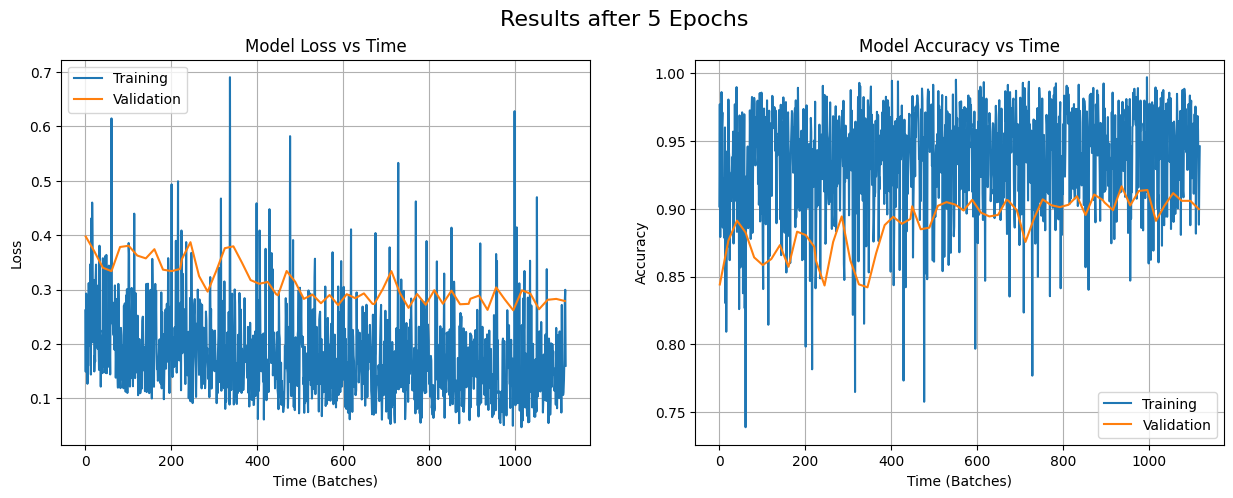

In [ ]:
# View model performance over time
plt.figure(figsize=(15, 5))

plt.suptitle('Results after 5 Epochs with Uniform Initialization', fontsize=16)

plt.subplot(121)
a, b = zip(*validation_losses) #unzips the tuple into two different variables (must have a start in it for this to occur) produces two lists
plt.plot(training_losses, label ='Training')
plt.plot(a, b, label='Validation')
plt.title('Model Loss vs Time')
plt.xlabel('Time (Batches)')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(122)
a, b = zip(*validation_accuracies) #unzips the tuple into two different variables (must have a start in it for this to occur) produces two lists
plt.plot(training_accuracies, label ='Training')
plt.plot(a, b, label='Validation')
plt.title('Model Accuracy vs Time')
plt.xlabel('Time (Batches)')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

epoch: 0, batch: 223, loss: 0.2646, accuracy: 0.918, remaining memory: 13.91: 100%|██████████| 224/224 [01:46<00:00,  2.34it/s]

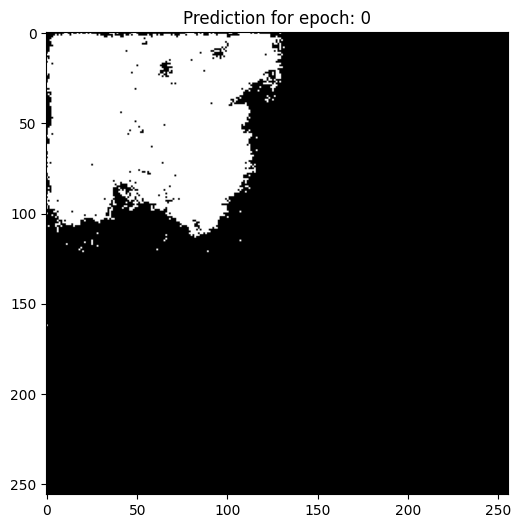

epoch: 0, batch: 223, loss: 0.2646, accuracy: 0.918, remaining memory: 13.91: 100%|██████████| 224/224 [01:46<00:00,  2.11it/s]
epoch: 1, batch: 223, loss: 0.1567, accuracy: 0.955, remaining memory: 13.91: 100%|██████████| 224/224 [01:45<00:00,  2.36it/s]

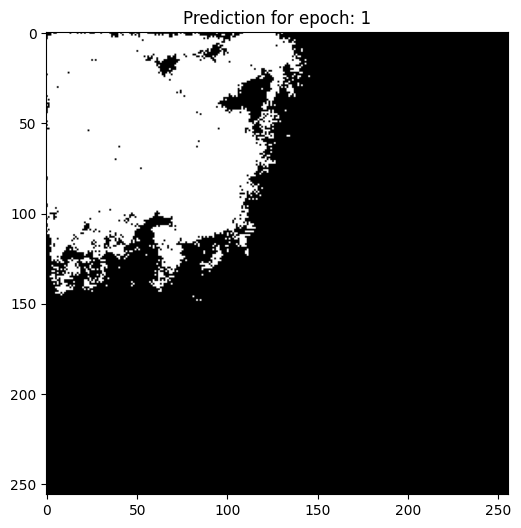

epoch: 1, batch: 223, loss: 0.1567, accuracy: 0.955, remaining memory: 13.91: 100%|██████████| 224/224 [01:45<00:00,  2.11it/s]
epoch: 2, batch: 223, loss: 0.2118, accuracy: 0.945, remaining memory: 13.91: 100%|██████████| 224/224 [01:45<00:00,  2.36it/s]

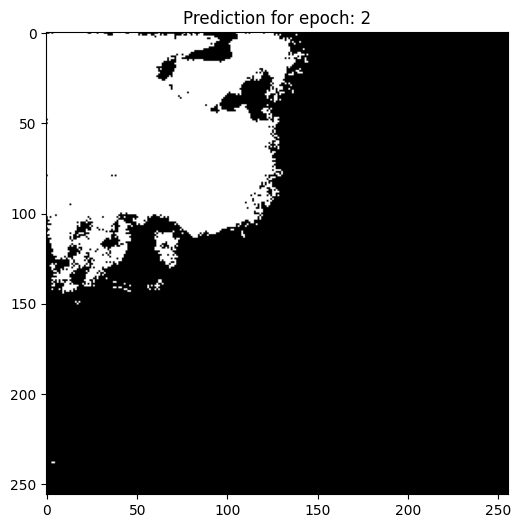

epoch: 2, batch: 223, loss: 0.2118, accuracy: 0.945, remaining memory: 13.91: 100%|██████████| 224/224 [01:45<00:00,  2.12it/s]
epoch: 3, batch: 223, loss: 0.1281, accuracy: 0.968, remaining memory: 13.91: 100%|██████████| 224/224 [01:45<00:00,  2.37it/s]

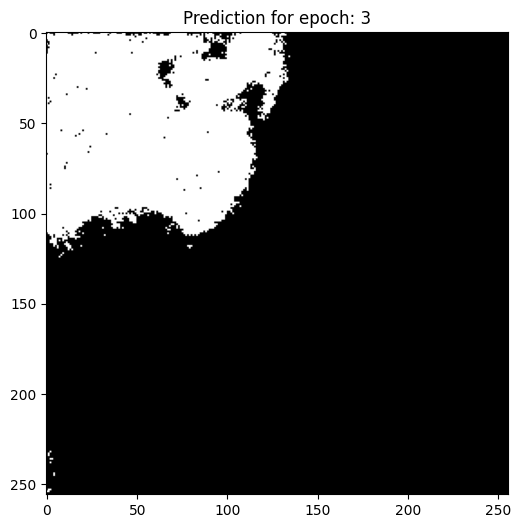

epoch: 3, batch: 223, loss: 0.1281, accuracy: 0.968, remaining memory: 13.91: 100%|██████████| 224/224 [01:45<00:00,  2.12it/s]
epoch: 4, batch: 223, loss: 0.1771, accuracy: 0.939, remaining memory: 13.91: 100%|██████████| 224/224 [01:45<00:00,  2.40it/s]

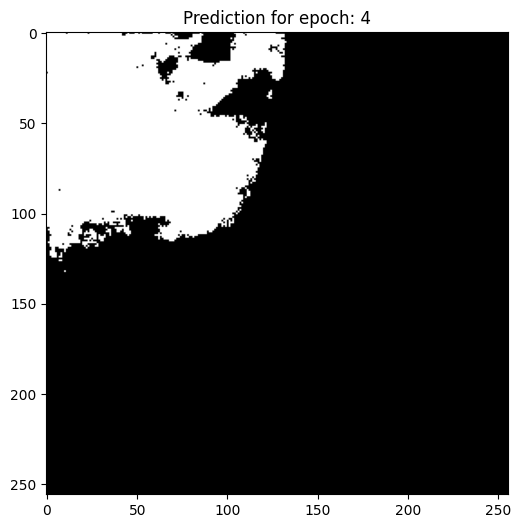

epoch: 4, batch: 223, loss: 0.1771, accuracy: 0.939, remaining memory: 13.91: 100%|██████████| 224/224 [01:45<00:00,  2.13it/s]
epoch: 5, batch: 223, loss: 0.0541, accuracy: 0.995, remaining memory: 13.91: 100%|██████████| 224/224 [01:44<00:00,  2.40it/s]

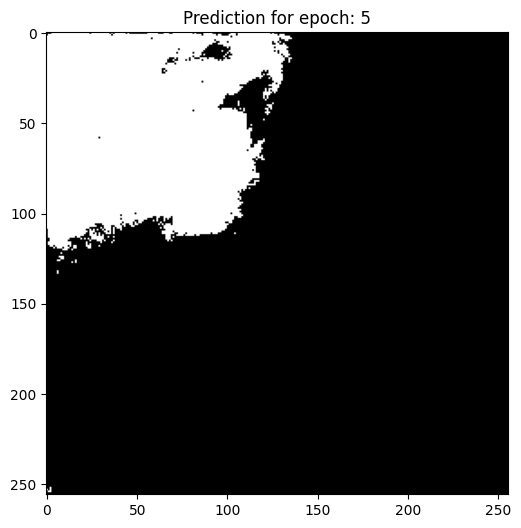

epoch: 5, batch: 223, loss: 0.0541, accuracy: 0.995, remaining memory: 13.91: 100%|██████████| 224/224 [01:44<00:00,  2.14it/s]
epoch: 6, batch: 223, loss: 0.0779, accuracy: 0.986, remaining memory: 13.91: 100%|██████████| 224/224 [01:43<00:00,  2.39it/s]

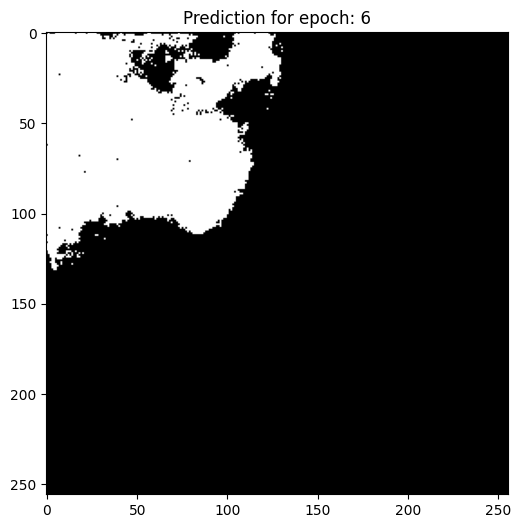

epoch: 6, batch: 223, loss: 0.0779, accuracy: 0.986, remaining memory: 13.91: 100%|██████████| 224/224 [01:43<00:00,  2.15it/s]
epoch: 7, batch: 223, loss: 0.1620, accuracy: 0.941, remaining memory: 13.91: 100%|██████████| 224/224 [01:43<00:00,  2.38it/s]

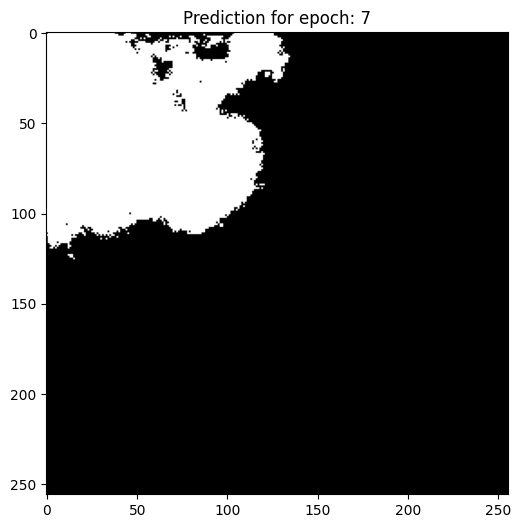

epoch: 7, batch: 223, loss: 0.1620, accuracy: 0.941, remaining memory: 13.91: 100%|██████████| 224/224 [01:44<00:00,  2.15it/s]
epoch: 8, batch: 223, loss: 0.0593, accuracy: 0.979, remaining memory: 13.91: 100%|██████████| 224/224 [01:44<00:00,  2.36it/s]

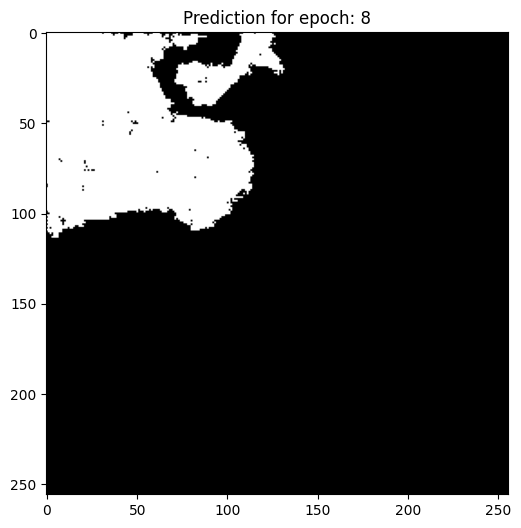

epoch: 8, batch: 223, loss: 0.0593, accuracy: 0.979, remaining memory: 13.91: 100%|██████████| 224/224 [01:44<00:00,  2.14it/s]
epoch: 9, batch: 223, loss: 0.0491, accuracy: 1.000, remaining memory: 13.91: 100%|██████████| 224/224 [01:43<00:00,  2.42it/s]

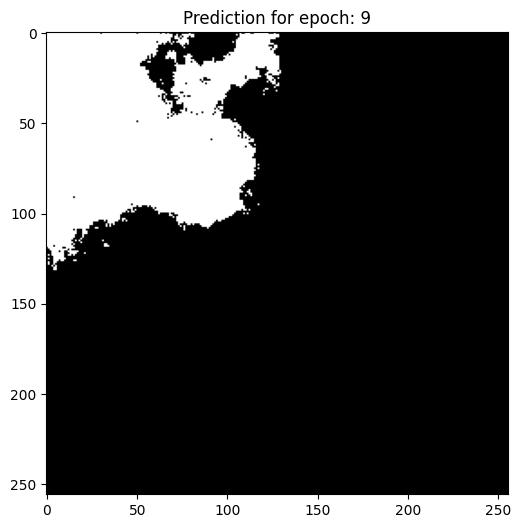

epoch: 9, batch: 223, loss: 0.0491, accuracy: 1.000, remaining memory: 13.91: 100%|██████████| 224/224 [01:43<00:00,  2.16it/s]


In [ ]:
# Traing the model, but this time show predictions
training_losses, training_accuracies, validation_losses, validation_accuracies = scope(validation=False, predictions=True)

# Play an audio beep to alert you that the training is done - this only works in Google Colab
from google.colab import output
output.eval_js('new Audio("http://www.waveevents.com/MyFilez/wavs/starwars/r2d2n15.wav").play()')

Text(0.5, 1.0, 'Ground Truth Mask')

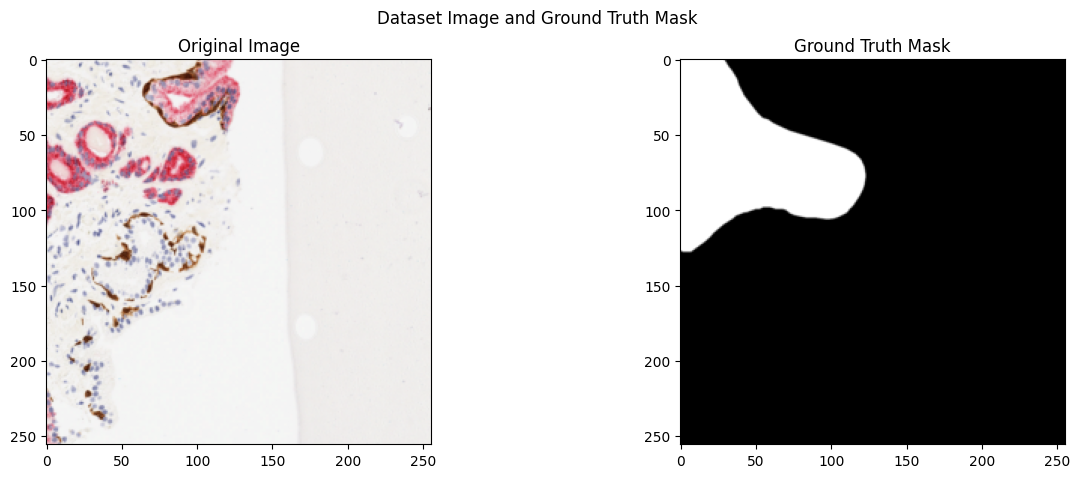

In [ ]:
# Show the image and the mask that was used for the prediction
image = val_dataset[172][0].numpy()
image = np.transpose(image, (1, 2, 0))
mask = val_dataset[172][1].numpy()

plt.figure(figsize=(15,5))
plt.suptitle('Dataset Image and Ground Truth Mask')

plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(122)
plt.imshow(mask, cmap='gray')
plt.title('Ground Truth Mask')